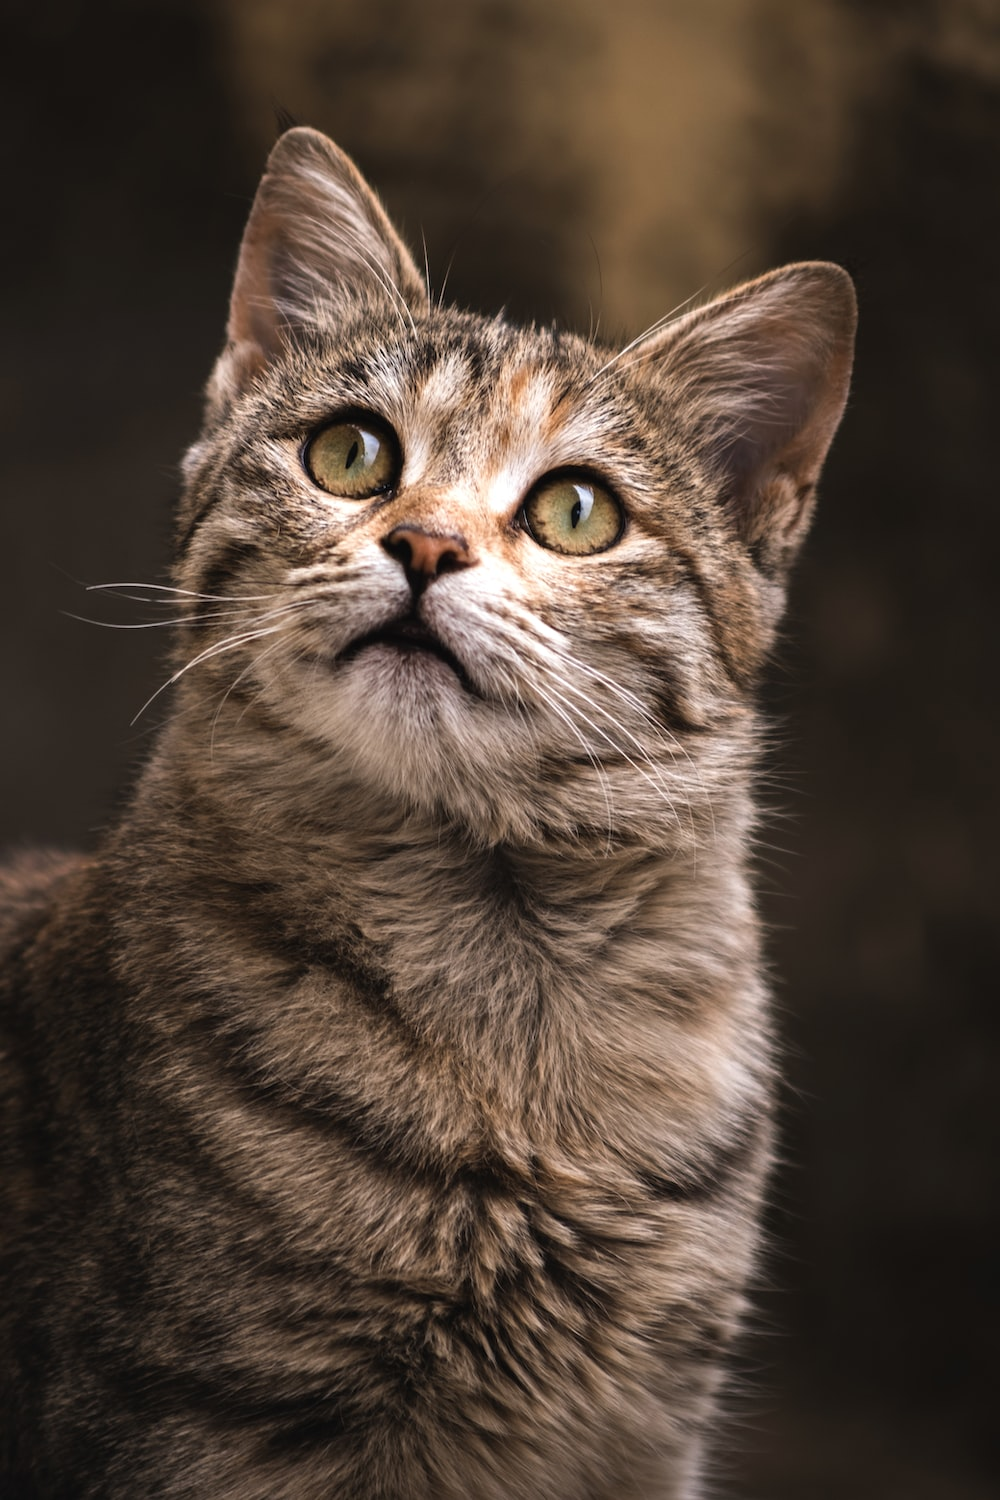

In [3]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = ('/content/drive/MyDrive/Internship_2023 /cat.jpeg')

display(Image(img_path))


In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02123045', 'tabby', 7.726169)]


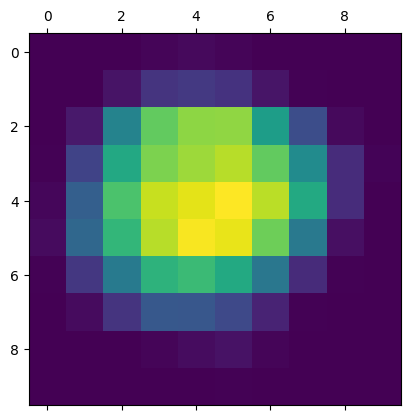

In [5]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


<ipython-input-8-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


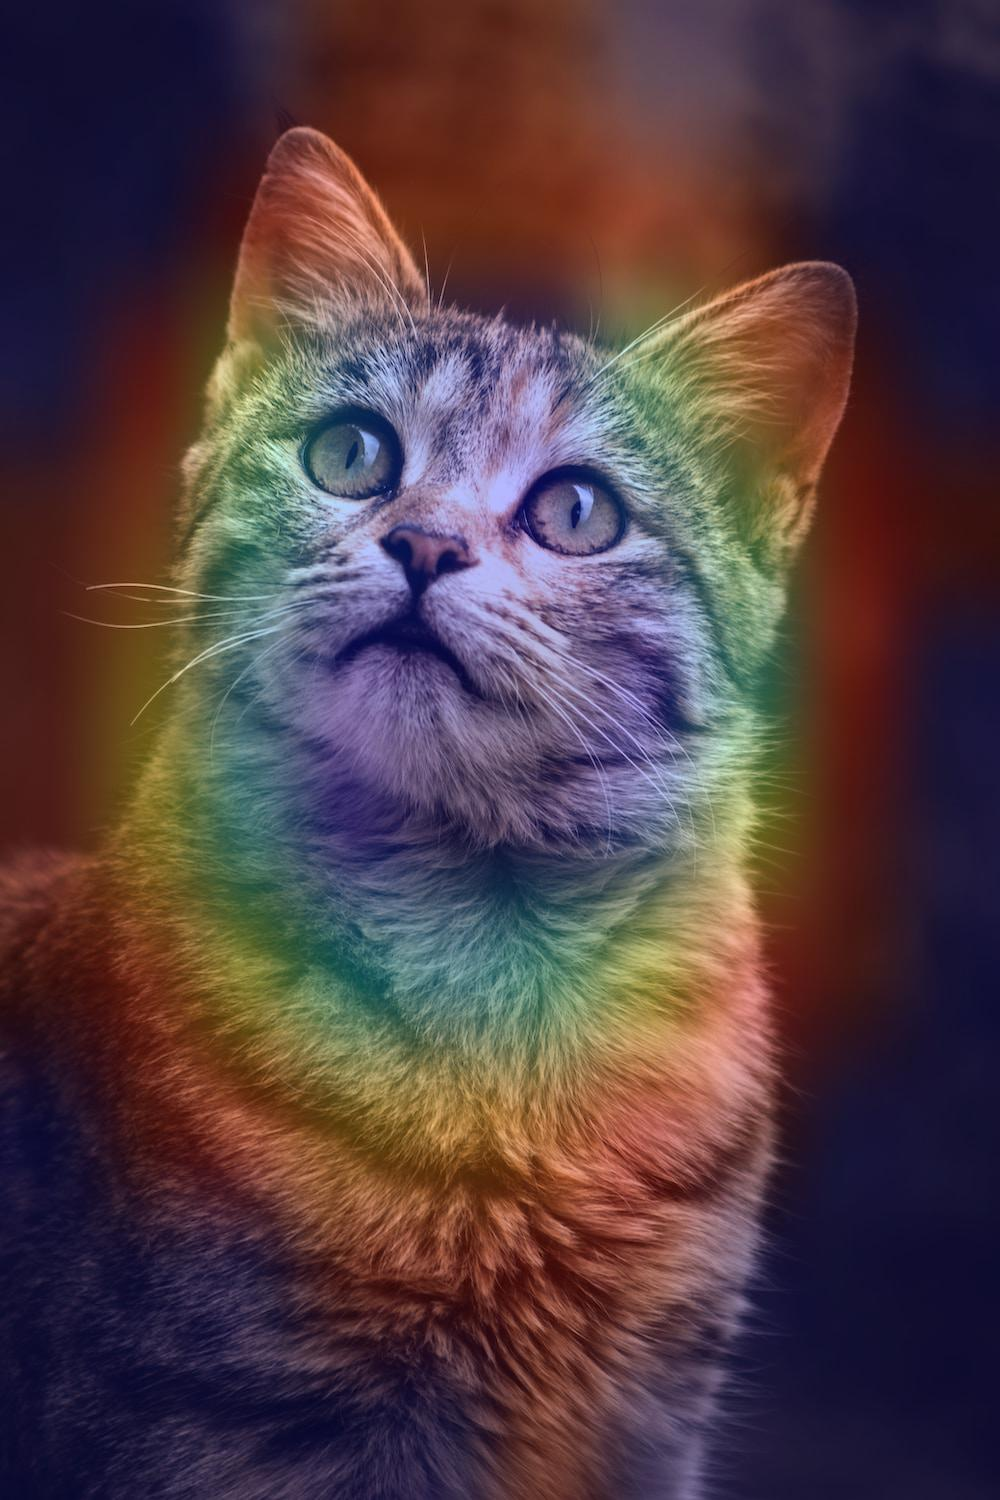

In [8]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

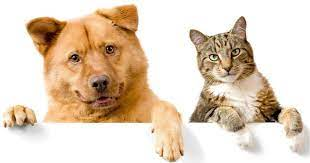

1/1 [==============================] - 0s 23ms/step
Predicted: [('n02112137', 'chow', 5.0323367), ('n02124075', 'Egyptian_cat', 4.355214)]


In [9]:
img_path = ('/content/drive/MyDrive/Internship_2023 /cat and dog.jpeg')

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

<ipython-input-8-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


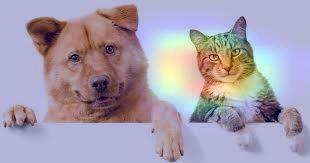

In [11]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)